In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from lifelines import KaplanMeierFitter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

In [2]:
rmf = pd.read_csv('rmf.csv')
rmf = rmf.drop(columns=['Unnamed: 0'])
rmf.head(2)

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,RFM_Label
0,12413.0,66,37,676.15,1,2,1,4,Lost Customers
1,12426.0,194,29,510.73,1,5,2,8,Loyal Customers


In [3]:
cohort_data = pd.read_csv('cohort_data.csv')
cohort_data = cohort_data.drop(columns=['Unnamed: 0'])
cohort_data['InvoiceDate'] = pd.to_datetime(cohort_data['InvoiceDate'])
cohort_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend,Year,Month,Day_of_Week,Is_weekend,OrderMonth,CohortMonth,CohortIndex,FirstPurchaseDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,Wednesday,0,2010-12,2010-12,0,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,Wednesday,0,2010-12,2010-12,0,2010-12-01


In [4]:
# Remove the return products
cohort_data = cohort_data[cohort_data['UnitPrice']>0]

customer_data = cohort_data.groupby(['Country', 'CustomerID']).agg(
    one_dollar_product=('UnitPrice', lambda x: ((x <= 1) & (x > 0)).sum()),
    two_dollar_product=('UnitPrice', lambda x: ((x <= 2) & (x > 1)).sum()),
    three_dollar_product=('UnitPrice', lambda x: ((x <= 3) & (x > 2)).sum()),
    above_3_product=('UnitPrice', lambda x: (x > 3).sum()),
    last_purchase_date=('InvoiceDate', 'max')
).reset_index()
customer_data

,Country,CustomerID,one_dollar_product,two_dollar_product,three_dollar_product,above_3_product,last_purchase_date
0,EIRE,14016.0,44,35,24,59,2011-07-08 14:27:00
1,EIRE,14156.0,229,404,275,511,2011-11-30 10:54:00
2,EIRE,14911.0,1338,1411,1028,2119,2011-12-08 15:54:00
3,France,12413.0,9,3,11,14,2011-10-04 09:00:00
4,France,12437.0,59,60,27,39,2011-12-08 11:35:00
...,...,...,...,...,...,...,...
4122,United Kingdom,18280.0,0,0,4,6,2011-03-07 09:52:00
4123,United Kingdom,18281.0,3,1,1,2,2011-06-12 10:53:00
4124,United Kingdom,18282.0,4,0,3,6,2011-12-02 11:43:00
4125,United Kingdom,18283.0,241,287,195,31,2011-12-06 12:02:00


In [5]:
# Merge the dataset
only_rmf = rmf[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']]
customer_behaviour = pd.merge(only_rmf, customer_data, how='left', on=['CustomerID'])


In [6]:
# Find the last date of this dataset
max_date = max(cohort_data['InvoiceDate'])

# Calculate the churn
churn_threshold = 89 # The mean recency is 89 days
churn_date89 = max_date - timedelta(days=churn_threshold)
churn_date30 = max_date - timedelta(days=30)
churn_date60 = max_date - timedelta(days=60)

print('Last day of this dataset:', max_date)
print('Chun date30:', churn_date30)

Last day of this dataset: 2011-12-09 12:50:00
Chun date30: 2011-11-09 12:50:00


In [7]:
# Create Churn column
def determine_churn(last_purchase_date):
    if last_purchase_date > churn_date30:
        return 'Active'
    elif churn_date60 <= last_purchase_date <= churn_date30:
        return 'Churn_30days'
    elif churn_date89 <= last_purchase_date < churn_date60:
        return 'Churn_60days'
    elif last_purchase_date < churn_date89:
        return 'Churn_89days'

customer_behaviour['Churn_Status'] = customer_behaviour['last_purchase_date'].apply(determine_churn)
churn_one_hot = pd.get_dummies(customer_behaviour['Churn_Status'])
churn_one_hot = churn_one_hot.astype(int)
customer_behaviour = pd.concat([customer_behaviour, churn_one_hot], axis=1)

customer_behaviour.head(2)


,CustomerID,Recency,Frequency,MonetaryValue,Country,one_dollar_product,two_dollar_product,three_dollar_product,above_3_product,last_purchase_date,Churn_Status,Active,Churn_30days,Churn_60days,Churn_89days
0,12413.0,66,37,676.15,France,9,3,11,14,2011-10-04 09:00:00,Churn_60days,0,0,1,0
1,12426.0,194,29,510.73,Germany,2,12,7,8,2011-05-29 12:26:00,Churn_89days,0,0,0,1


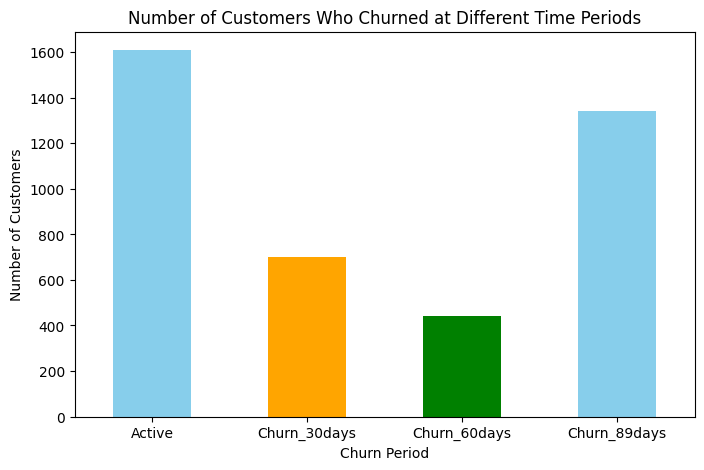

In [8]:
churn_summary = customer_behaviour[['Active', 'Churn_30days', 'Churn_60days', 'Churn_89days']].sum()

# Plot the data
churn_summary.plot(kind='bar', color=['skyblue', 'orange', 'green'], figsize=(8, 5))
plt.title('Number of Customers Who Churned at Different Time Periods')
plt.ylabel('Number of Customers')
plt.xlabel('Churn Period')
plt.xticks(rotation=0)
plt.show()

The retention strategy should focus on the 30-day period, as a large portion of churn occurs within this time frame.

_____

#### Product Price Ratios

In [9]:
customer_behaviour['total_products'] = customer_behaviour[['one_dollar_product', 'two_dollar_product', 
                                                           'three_dollar_product', 'above_3_product']].sum(axis=1)

customer_behaviour['cheap_product_ratio'] = customer_behaviour['one_dollar_product'] / customer_behaviour['total_products']
customer_behaviour['affortable_product_ratio'] = (customer_behaviour['two_dollar_product'] + customer_behaviour['three_dollar_product']) / customer_behaviour['total_products']
customer_behaviour['expensive_product_ratio'] = customer_behaviour['above_3_product'] / customer_behaviour['total_products']

ratio = customer_behaviour[['CustomerID', 'Country', 'MonetaryValue', 'cheap_product_ratio', 'affortable_product_ratio', 'expensive_product_ratio']]
ratio.head()

,CustomerID,Country,MonetaryValue,cheap_product_ratio,affortable_product_ratio,expensive_product_ratio
0,12413.0,France,676.15,0.243243,0.378378,0.378378
1,12426.0,Germany,510.73,0.068966,0.655172,0.275862
2,12427.0,Germany,582.37,0.062500,0.625000,0.312500
3,12437.0,France,4392.66,0.318919,0.470270,0.210811
4,12441.0,France,155.55,0.300000,0.500000,0.200000


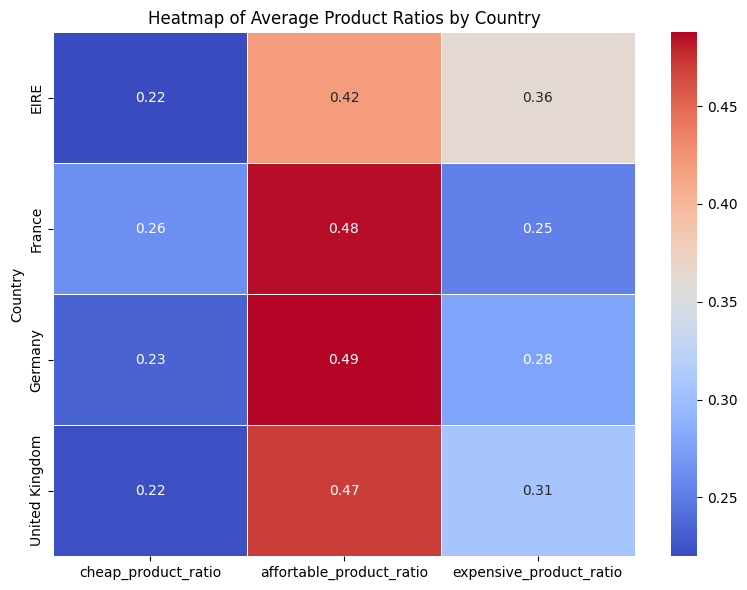

In [10]:
# Plot the heatmap
heatmap_data = ratio.pivot_table(index='Country', 
                                 values=['cheap_product_ratio', 'affortable_product_ratio', 'expensive_product_ratio'], 
                                 aggfunc='mean')

heatmap_data = heatmap_data[['cheap_product_ratio', 'affortable_product_ratio', 'expensive_product_ratio']]

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", linewidths=.5)
plt.title('Heatmap of Average Product Ratios by Country')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

________


#### KNN

In [23]:
customer_behaviour.head()

,CustomerID,Recency,Frequency,MonetaryValue,Country,one_dollar_product,two_dollar_product,three_dollar_product,above_3_product,last_purchase_date,Churn_Status,Active,Churn_30days,Churn_60days,Churn_89days,total_products,cheap_product_ratio,affortable_product_ratio,expensive_product_ratio,Cluster
0,12413.0,66,37,676.15,France,9,3,11,14,2011-10-04 09:00:00,Churn_60days,0,0,1,0,37,0.243243,0.378378,0.378378,2
1,12426.0,194,29,510.73,Germany,2,12,7,8,2011-05-29 12:26:00,Churn_89days,0,0,0,1,29,0.068966,0.655172,0.275862,2
2,12427.0,11,32,582.37,Germany,2,12,8,10,2011-11-28 10:48:00,Active,1,0,0,0,32,0.062500,0.625000,0.312500,2
3,12437.0,1,185,4392.66,France,59,60,27,39,2011-12-08 11:35:00,Active,1,0,0,0,185,0.318919,0.470270,0.210811,2
4,12441.0,366,10,155.55,France,3,1,4,2,2010-12-08 10:45:00,Churn_89days,0,0,0,1,10,0.300000,0.500000,0.200000,1


/var/folders/x_/08j42z3j22377xv4cbjvxw880000gn/T/ipykernel_49911/3971461504.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', color='blue')


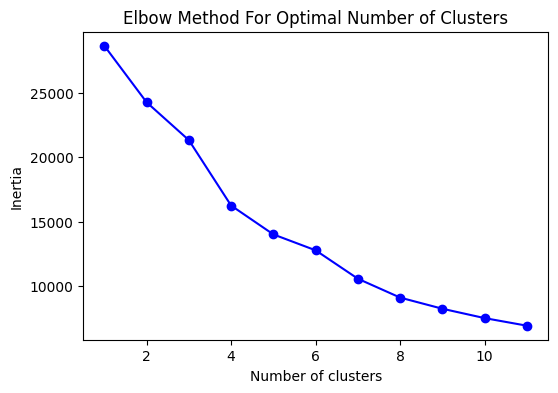

In [12]:
features = customer_behaviour[['Recency', 'Frequency', 'MonetaryValue', 'total_products', 
                               'cheap_product_ratio', 'affortable_product_ratio', 'expensive_product_ratio']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

inertia = []
K = range(1, 12)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the elbow method result
plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'bo-', color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()


In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_behaviour['Cluster'] = kmeans.fit_predict(scaled_features)

fig = px.scatter(customer_behaviour, 
                 x='Frequency', 
                 y='MonetaryValue', 
                 color='Cluster', 
                 size='Recency',
                 hover_data=['CustomerID'],
                 title='Customer Clusters by Frequency, Monetary Value, and Recency')

# Show the plot
fig.show()

In [20]:
numeric_columns = customer_behaviour.select_dtypes(include=['number']).columns.drop(['CustomerID', 'Active', 
                                                                                     'Churn_30days', 'Churn_60days', 'Churn_89days',
                                                                                     'one_dollar_product', 'two_dollar_product', 
                                                                                     'three_dollar_product', 'above_3_product', 'total_products'])

cluster_summary = customer_behaviour.groupby('Cluster')[numeric_columns].mean()
cluster_summary

,Recency,Frequency,MonetaryValue,cheap_product_ratio,affortable_product_ratio,expensive_product_ratio,Cluster
Cluster,,,,,,,
0,138.748252,37.608392,970.043487,0.103022,0.322383,0.574596,0.0
1,98.543558,51.771779,802.097902,0.487295,0.349232,0.163473,1.0
2,63.839136,124.433671,2459.590031,0.182843,0.580946,0.236211,2.0
3,1.000000,5896.750000,64271.327500,0.222294,0.454492,0.323214,3.0


Cluster 0: High-value but disengaged shoppers. Focus on reactivation.

Cluster 1: Budget-conscious, moderately engaged shoppers. Focus on promoting affordable products.

Cluster 2: Loyal, frequent shoppers with moderate-high spending. Focus on loyalty programs.

Cluster 3: Elite, extremely high-value customers. Focus on VIP treatment and exclusivity.

In [22]:
customer_behaviour.to_csv('customer_behaviour.csv')